# Analysis of 2D data (Python)

This Python notebook demonstrates how 2D data can be analyzed using **spm1d**.

<div class="alert alert-block alert-info">
<b>Note:</b> Currently <b>spm1d</b> can be used only for <a href="https://en.wikipedia.org/wiki/Nonparametric_statistics">non-parametric</a> analysis of 2D data.
</div>

<div class="alert alert-block alert-warning">
<b>Warning:</b> 2D data must be <a href="https://en.wikipedia.org/wiki/Image_registration">registered</a> prior to analysis. <b>spm1d</b> does not support 2D registration. Algorithmic registration of 2D data can be achieved with third-party software like <a href="https://itk.org">ITK</a>. Manual registration of 2D data is possible with software like <a href="https://www.slicer.org/wiki/Slicer3.4:Training#Slicer_3.4_Tutorials">3D Slicer</a>.
</div>

<div class="alert alert-block alert-warning">
<b>Warning:</b> Probability values can not be calculated.  Hypothesis testing is possible (i.e., critical test statistic calculation), but <b>spm1d</b> does not support cluster-specific probability calculations for 2D data.
</div>


___

### Dataset

The 2D data analyzed below are from [Pataky (2012)](https://www.sciencedirect.com/science/article/pii/S0021929012003193), and include 20 pressure plate measurements of quiet standing in a single subject. Ten measurements were made for each of two quiet standing tasks: backward leaning and forward leaning. For the first ten measurements the subject leaned backward while maintaining toe contact, and for the next ten measurements the subject leaned forward while maintaining heel contact. Pressure distributions were recorded at 50 Hz for 5 s with a spatial resolution of 8.5 mm.

The attached dataset represents the average 2D pressure distribution (units: kPa) over the 5 s recorded interval. Each of the 20 observations is saved as a (60 x 32) array of pressure values. While the subject was required to step off the measurement plate between each measurement, thus implying non-constant foot positions with respect to the measurement device's coordinate system, the attached data have been pre-registered following [Oliveira et al. (2010)](https://iom3.tandfonline.com/doi/abs/10.1080/10255840903573020).

The goal of the analyses below is to test the null hypothes of equal pressure distributions in the two tasks. 

#### References

Oliveira FP, Pataky TC, Tavares JM (2010). Registration of pedobarographic image data in the frequency domain. *Computer Methods in Biomechanics and Biomedical Engineering* 13(6): 731-40.

Pataky TC (2012). Spatial resolution in plantar pressure measurement revisited. *Journal of Biomechanics* 45(12): 2116-24.

___

### Importing and visualizing the data

The data are saved the "data2d" file and can be imported as follows:

In [1]:
import numpy as np
from matplotlib import pyplot

fname = 'data2d.npy'
Y     = np.load(fname)

print(Y.shape)

(20, 60, 32)


Note that the data are saved in a single 3D array with dimensions (20, 60, 32), implying 20 measurements of (60 x 32) pressure distributions. Individual observations can be visualized like this:

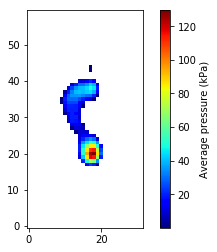

In [2]:
pyplot.figure()
ax = pyplot.axes()
ax.imshow(np.ma.masked_array(Y[0], Y[0]==0), origin='lower', cmap='jet')
cb = pyplot.colorbar(mappable=ax.images[0])
cb.set_label('Average pressure (kPa)')
pyplot.show()

This represents a single observation of backward leaning. All observations can be visualized as follows.

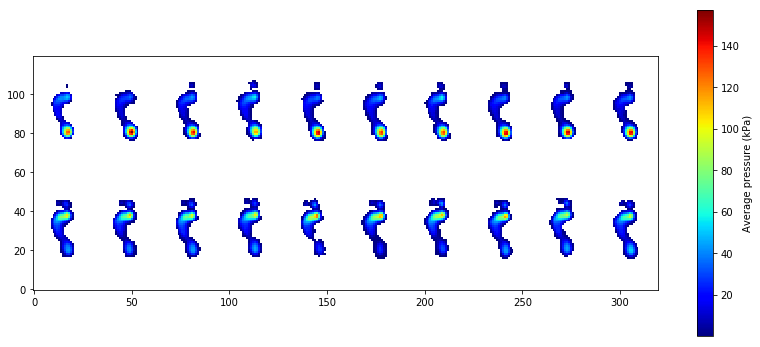

In [3]:
y0,y1 = Y[:10], Y[10:]
y     = np.vstack([np.hstack(y1),np.hstack(y0)])

pyplot.figure( figsize=(14,6) )
ax = pyplot.axes()
ax.imshow(np.ma.masked_array(y, y==0), origin='lower', cmap='jet')
cb = pyplot.colorbar(mappable=ax.images[0])
cb.set_label('Average pressure (kPa)')
pyplot.show()


The backward and forward leaning trials are depicted in the top and bottom rows, respectively.

The mean distributions for the two tasks can be computed and visualized as follows:

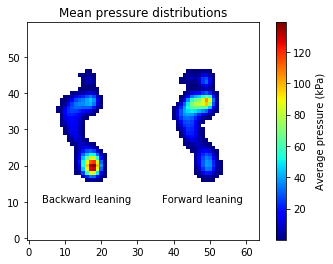

In [4]:
mA  = Y[:10].mean(axis=0)
mB  = Y[10:].mean(axis=0)
m   = np.hstack( [mA, mB] )

pyplot.figure()
ax = pyplot.axes()
ax.imshow(np.ma.masked_array(m, m==0), origin='lower', cmap='jet')
ax.set_title('Mean pressure distributions')
ax.text(16, 10, 'Backward leaning', ha='center')
ax.text(48, 10, 'Forward leaning', ha='center')
cb = pyplot.colorbar(mappable=ax.images[0])
cb.set_label('Average pressure (kPa)')
pyplot.show()

___

### Statistical analysis

A two-sample t test can be conducted on these data using **spm1d** as follows.

##### Step 1:  Flatten the data

The data must be flattened so that each observation is a 1D array.

In [5]:
y       = np.array([yy.flatten() for yy in Y])
J,Q     = y.shape

print(J, Q)

20 1920


Here J is the number of observations and Q is the number of nodes in the flattened 1D array.

##### Step 2: Remove zero-variance nodes

For some types of 2D data, including the pressure distributions above, some nodes can contain zeros for all observations, implying zero variance and thus that test statistic values cannot be computed for these nodes. To avoid this problem it is desireable to remove zero-variance nodes like this: 

In [6]:
#separate the observations:
yA      = y[:10]  #flattend observations for Task A
yB      = y[10:]  #flattend observations for Task B

#find zero-variance nodes:
eps     = np.finfo(float).eps     #smallest float number
iA      = yA.std(axis=0) > eps    #Task A indices where variance > 0
iB      = yB.std(axis=0) > eps    #Task B indices where variance > 0
i       = np.logical_and(iA, iB)  #indices where variance > 0 for both tasks

ynz     = y[:,i]    #all observations with non-zero variance nodes removed
ynzA    = ynz[:10]  #Task A observations with non-zero variance nodes removed
ynzB    = ynz[10:]  #Task B observations with non-zero variance nodes removed

##### Step 3:  Run statistical analysis

Here a two-sample t test will be used. Note that the same procedure can be used for any test in **spm1d.stats.nonparam**.

In [7]:
import spm1d

snpm    = spm1d.stats.nonparam.ttest2(ynzA, ynzB)
snpmi   = snpm.inference(0.05, two_tailed=True, iterations=10000)

That's it!

Here ```alpha=0.05``` is the Type I error rate, and ```iterations=10000``` is the number of iterartions used to build the nonparametric distribution for the test statistic. The number of iterations should be as large as is necessary to achieve numerical stability in the critical threshold, which is indicated below. Here "numerical stability" implies that quantitative changes in the critical test statistic value do not produce qualitative changes in the statistical results. Quantitative changes in the critical test statistic arise due changes in the number of iterations and/or in the randomization state. 

As a rule-of-thumb, at least 1000 iterations are needed, with 10,000 preferred. Also as a rule-of-thumb, run an re-run analyses a number of times to ensure numerical stability.

##### Step 4:  Visualize the results

The **spm1d** results need to be reverted to the original 2D state for visualization. This can be achieved as follows.

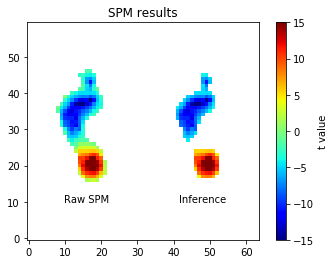

In [8]:
znz     = snpmi.z      #flattened test statistic  (i.e., t value) over only non-zero-variance nodes
zstar   = snpmi.zstar  #critical test statistic  (i.e., critical t value)

z       = np.zeros(Q)  #flattened test statistic including all nodes
z[i]    = znz          #add test statistic values for the non-zero-variance nodes

Z       = np.reshape(z, Y.shape[1:])   #2D test statistic image
Zi      = Z.copy()                     #2D inference image (temporary)
Zi[np.abs(Z)<zstar] = 0                #thresholded test statistic image

ZZ      = np.hstack( [Z, Zi] )         #both raw test statistic image and inference image


#plot:
pyplot.figure()
ax = pyplot.axes()
ax.imshow(np.ma.masked_array(ZZ, ZZ==0), origin='lower', cmap='jet', vmin=-15, vmax=15)
ax.set_title('SPM results')
ax.text(16, 10, 'Raw SPM', ha='center')
ax.text(48, 10, 'Inference', ha='center')
cb = pyplot.colorbar(mappable=ax.images[0])
cb.set_label('t value')
pyplot.show()

The "Raw SPM" image depicts the t values for all non-zero-variance nodes. The "Inference" image is the same, but is thresholded using the critical test statistic. In this case there are nodes whose t values exceed the critical t value, implying that the null hypothesis is rejected.

___

### Summary

**spm1d** can be used to conduct nonparametric statistical inference on 2D data, but currently only supports hypothesis testing (i.e., critical test statistic calculation) and does not provide cluster-specific p values. Users requiring cluster-specific values can use another SPM packages like [SPM12](https://www.fil.ion.ucl.ac.uk/spm/software/spm12/) or [nipy](https://nipy.org).